# Resampling Procedure

- Experiment with Downsampling and Oversampling methods on Random Forest & Gradient Boosting Model (selected due to respectively high preformance compared to other baseline models)
- Combination of Downsampling and Oversampling is used to generate the final resampled dataset for modeling
    - Different Thresholds are tested on RF and GB 

### Prepare and Load Transformed Data 

In [5]:
# import packages
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
from collections import Counter
from sklearn.model_selection import GridSearchCV
from itertools import product


In [6]:
# read train and test data in Transformed_Data
X_test = pd.read_csv('../Transformed_Data/X_test.csv')
X_train = pd.read_csv('../Transformed_Data/X_train.csv')
y_test = pd.read_csv('../Transformed_Data/y_test.csv')
y_train = pd.read_csv('../Transformed_Data/y_train.csv')

## Modeling Without Resampling

Baseline Random Forest and Gradient Boosting Results

In [7]:
# model training RF
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train.values.ravel())

# predict the test data
y_pred_rf = rf.predict(X_test)

print('RF Accuracy: ', accuracy_score(y_test, y_pred_rf))
print('RF Precision: ', precision_score(y_test, y_pred_rf))
print('RF Recall: ', recall_score(y_test, y_pred_rf))
print('RF F1 Score: ', f1_score(y_test, y_pred_rf))
print('RF Confusion Matrix: ', confusion_matrix(y_test, y_pred_rf))

RF Accuracy:  0.9916540212443096
RF Precision:  1.0
RF Recall:  0.043478260869565216
RF F1 Score:  0.08333333333333333
RF Confusion Matrix:  [[2613    0]
 [  22    1]]


In [8]:
# model training GB
gb = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)

# Fit the model to the training data
gb.fit(X_train, y_train)

# Predict the labels for the test set
y_pre_gb = gb.predict(X_test)
y_pred_prob_gb = gb.predict_proba(X_test)[:, 1]

# Print the model's performance
print('GB Accuracy: ', accuracy_score(y_test, y_pre_gb))
print('GB Precision: ', precision_score(y_test, y_pre_gb))
print('GB Recall: ', recall_score(y_test, y_pre_gb))
print('GB F1 Score: ', f1_score(y_test, y_pre_gb))
print('GB Confusion Matrix: ', confusion_matrix(y_test, y_pre_gb))

/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GB Accuracy:  0.9897572078907435
GB Precision:  0.25
GB Recall:  0.08695652173913043
GB F1 Score:  0.12903225806451613
GB Confusion Matrix:  [[2607    6]
 [  21    2]]


## Resampling : Oversample + Downsample

In [9]:
# Separate majority and minority classes
majority_class = X_train[y_train['successful'] == 0]
minority_class = X_train[y_train['successful'] == 1]
majority_labels = y_train[y_train['successful'] == 0]
minority_labels = y_train[y_train['successful'] == 1]

In [10]:
# print length of majority and minority classes
print('Majority Class Length: ', len(majority_class))
print('Minority Class Length: ', len(minority_class))

Majority Class Length:  10452
Minority Class Length:  89


In [11]:
# Grid search for RF on oversample and downsample proportion

# Define the parameter grid
param_grid = {
    'oversample_size': [178, 267, 356, 445, 534, 623, 712, 801, 890],
    'downsample_size': [9000, 8000, 7000, 6000, 5000, 4000, 3000, 2000, 1000, 500]
}

# Store results for each parameter combination
results = []
results_gb = []

# Iterate over each combination of oversample and downsample sizes
for oversample_size, downsample_size in product(param_grid['oversample_size'], param_grid['downsample_size']):
    # Upsample the minority class
    minority_upsampled = resample(
        minority_class,
        replace=True,
        n_samples=oversample_size,
        random_state=42
    )
    minority_labels_upsampled = resample(
        minority_labels,
        replace=True,
        n_samples=oversample_size,
        random_state=42
    )

    # Downsample the majority class
    majority_downsampled = resample(
        majority_class,
        replace=False,
        n_samples=downsample_size,
        random_state=42
    )
    majority_labels_downsampled = resample(
        majority_labels,
        replace=False,
        n_samples=downsample_size,
        random_state=42
    )

    # Combine the resampled classes
    X_train_resampled = pd.concat([majority_downsampled, minority_upsampled]).reset_index(drop=True)
    y_train_resampled = pd.concat([majority_labels_downsampled, minority_labels_upsampled]).reset_index(drop=True)

    # Train the model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_resampled, y_train_resampled)

    # Predict on the test data
    y_pred = rf_model.predict(X_test)
    y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store the results
    results.append({
        'oversample_size': oversample_size,
        'downsample_size': downsample_size,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred)
    })

    # Train Gradient Boosting Model
    gb_model = GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    )
    gb_model.fit(X_train_resampled, y_train_resampled)

    # Predict on the test data
    y_pred_gb = gb_model.predict(X_test)
    y_pred_prob_gb = gb_model.predict_proba(X_test)[:, 1]

    # Calculate evaluation metrics
    accuracy_gb = accuracy_score(y_test, y_pred_gb)
    f1_gb = f1_score(y_test, y_pred_gb)
    conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

    # Store the results
    results_gb.append({
        'oversample_size': oversample_size,
        'downsample_size': downsample_size,
        'accuracy': accuracy_gb,
        'f1_score': f1_gb,
        'recall': recall_score(y_test, y_pred_gb),
        'precision': precision_score(y_test, y_pred_gb)
    })

# Display the results as a DataFrame for easier analysis
results_df = pd.DataFrame(results)
results_df.sort_values(by='recall', ascending=False, inplace=True)  # Sort by best recall
print(results_df)

/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

    oversample_size  downsample_size  accuracy  f1_score    recall  precision
89              890              500  0.942716  0.201058  0.826087   0.114458
29              356              500  0.948407  0.218391  0.826087   0.125828
79              801              500  0.945372  0.208791  0.826087   0.119497
59              623              500  0.939681  0.184615  0.782609   0.104651
19              267              500  0.960926  0.258993  0.782609   0.155172
..              ...              ...       ...       ...       ...        ...
62              712             7000  0.990516  0.074074  0.043478   0.250000
63              712             6000  0.990895  0.076923  0.043478   0.333333
24              356             5000  0.990895  0.076923  0.043478   0.333333
23              356             6000  0.990516  0.074074  0.043478   0.250000
0               178             9000  0.991275  0.080000  0.043478   0.500000

[90 rows x 6 columns]


In [18]:
# print all with recall > 0.7
print(results_df[results_df['recall'] > 0.5])

    oversample_size  downsample_size  accuracy  f1_score    recall  precision
38              445             1000  0.977238  0.302326  0.565217   0.206349
19              267              500  0.960926  0.258993  0.782609   0.155172
88              890             1000  0.973824  0.258065  0.521739   0.171429
58              623             1000  0.973445  0.255319  0.521739   0.169014
9               178              500  0.963202  0.236220  0.652174   0.144231
29              356              500  0.948407  0.218391  0.826087   0.125828
79              801              500  0.945372  0.208791  0.826087   0.119497
49              534              500  0.949165  0.202381  0.739130   0.117241
89              890              500  0.942716  0.201058  0.826087   0.114458
69              712              500  0.943854  0.195652  0.782609   0.111801
59              623              500  0.939681  0.184615  0.782609   0.104651
39              445              500  0.946510  0.175439  0.6521

In [14]:
# RF
# Sort by F1 score
results_df = pd.DataFrame(results)
results_df.sort_values(by='f1_score', ascending=False, inplace=True)  # Sort by best f1
print(results_df)

    oversample_size  downsample_size  accuracy  f1_score    recall  precision
57              623             2000  0.990516  0.324324  0.260870   0.428571
38              445             1000  0.977238  0.302326  0.565217   0.206349
77              801             2000  0.988619  0.285714  0.260870   0.315789
86              890             3000  0.990516  0.285714  0.217391   0.416667
47              534             2000  0.990137  0.277778  0.217391   0.384615
..              ...              ...       ...       ...       ...        ...
16              267             3000  0.990137  0.071429  0.043478   0.200000
73              801             6000  0.990137  0.071429  0.043478   0.200000
32              445             7000  0.990137  0.071429  0.043478   0.200000
35              445             4000  0.989757  0.068966  0.043478   0.166667
34              445             5000  0.989757  0.068966  0.043478   0.166667

[90 rows x 6 columns]


In [15]:
results_gb_df = pd.DataFrame(results_gb)
results_gb_df.sort_values(by='recall', ascending=False, inplace=True)  # Sort by best recall
print(results_gb_df)

    oversample_size  downsample_size  accuracy  f1_score    recall  precision
89              890              500  0.896813  0.133758  0.913043   0.072165
69              712              500  0.905539  0.144330  0.913043   0.078358
29              356              500  0.924127  0.173554  0.913043   0.095890
79              801              500  0.900228  0.137705  0.913043   0.074468
39              445              500  0.921472  0.168675  0.913043   0.092920
..              ...              ...       ...       ...       ...        ...
4               178             5000  0.990895  0.142857  0.086957   0.400000
3               178             6000  0.990516  0.137931  0.086957   0.333333
1               178             8000  0.991275  0.080000  0.043478   0.500000
2               178             7000  0.990137  0.071429  0.043478   0.200000
0               178             9000  0.990895  0.076923  0.043478   0.333333

[90 rows x 6 columns]


In [16]:
# print all with recall > 0.65
print(results_gb_df[results_gb_df['recall'] > 0.65])

    oversample_size  downsample_size  accuracy  f1_score    recall  precision
89              890              500  0.896813  0.133758  0.913043   0.072165
69              712              500  0.905539  0.144330  0.913043   0.078358
29              356              500  0.924127  0.173554  0.913043   0.095890
79              801              500  0.900228  0.137705  0.913043   0.074468
39              445              500  0.921472  0.168675  0.913043   0.092920
59              623              500  0.906297  0.145329  0.913043   0.078947
49              534              500  0.907815  0.147368  0.913043   0.080153
88              890             1000  0.932473  0.190909  0.913043   0.106599
48              534             1000  0.946510  0.220994  0.869565   0.126582
19              267              500  0.939681  0.201005  0.869565   0.113636
38              445             1000  0.954856  0.251572  0.869565   0.147059
78              801             1000  0.935888  0.191388  0.8695

In [23]:
# GB
# Sort by F1 score
results_gb_df = pd.DataFrame(results_gb)
results_gb_df.sort_values(by='f1_score', ascending=False, inplace=True)  # Sort by best f1
print(results_gb_df)

    oversample_size  downsample_size  accuracy  f1_score    recall  precision
52              623             7000  0.990137  0.380952  0.347826   0.421053
80              890             9000  0.988619  0.375000  0.391304   0.360000
51              623             8000  0.990516  0.358974  0.304348   0.437500
26              356             3000  0.985964  0.350877  0.434783   0.294118
86              890             3000  0.976100  0.350515  0.739130   0.229730
..              ...              ...       ...       ...       ...        ...
79              801              500  0.900228  0.137705  0.913043   0.074468
89              890              500  0.896813  0.133758  0.913043   0.072165
1               178             8000  0.991275  0.080000  0.043478   0.500000
0               178             9000  0.990895  0.076923  0.043478   0.333333
2               178             7000  0.990137  0.071429  0.043478   0.200000

[90 rows x 6 columns]


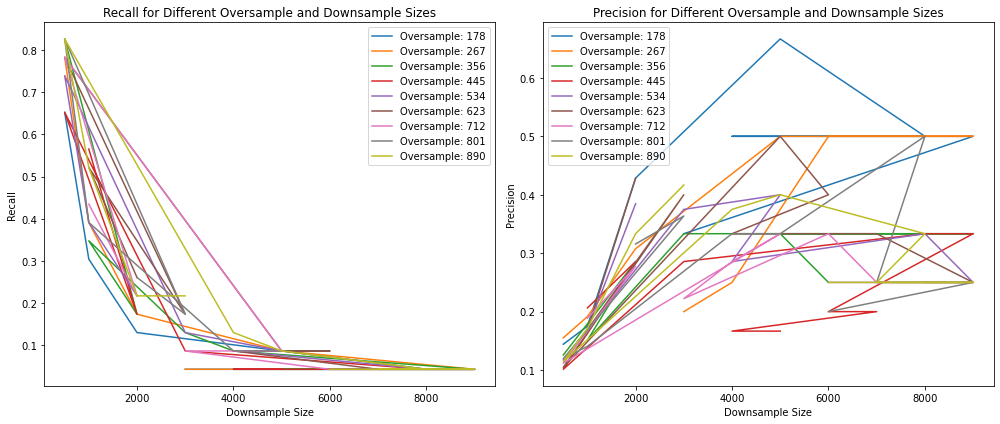

In [20]:
# Ensure columns are converted to numeric arrays
results_df['downsample_size'] = results_df['downsample_size'].astype(int)
results_df['precision'] = results_df['precision'].astype(float)
results_df['recall'] = results_df['recall'].astype(float)

# Plot Precision and Recall for each combination
plt.figure(figsize=(14, 6))

# Plot Recall
plt.subplot(1, 2, 1)
for oversample_size in param_grid['oversample_size']:
    subset = results_df[results_df['oversample_size'] == oversample_size]
    plt.plot(subset['downsample_size'].values, subset['recall'].values, label=f'Oversample: {oversample_size}')
plt.xlabel('Downsample Size')
plt.ylabel('Recall')
plt.title('Recall for Different Oversample and Downsample Sizes')
plt.legend()

# Plot Precision
plt.subplot(1, 2, 2)
for oversample_size in param_grid['oversample_size']:
    subset = results_df[results_df['oversample_size'] == oversample_size]
    plt.plot(subset['downsample_size'].values, subset['precision'].values, label=f'Oversample: {oversample_size}')
plt.xlabel('Downsample Size')
plt.ylabel('Precision')
plt.title('Precision for Different Oversample and Downsample Sizes')
plt.legend()

plt.tight_layout()
plt.show()

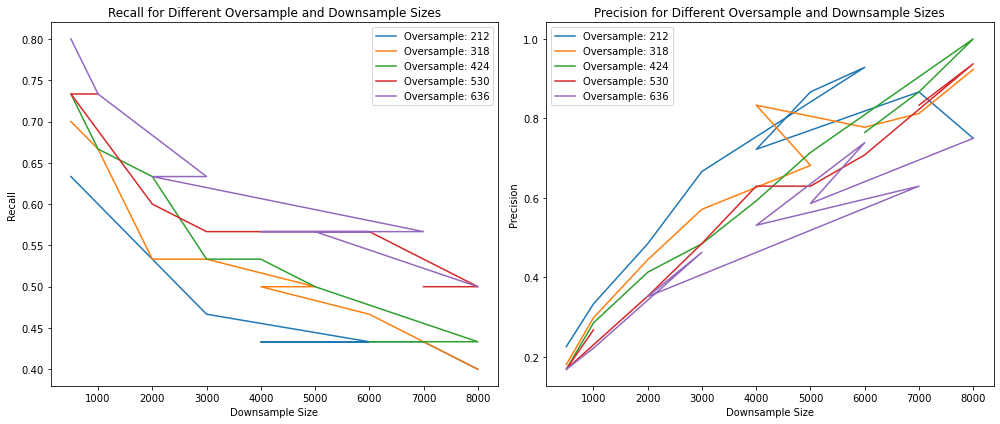

In [24]:
# Ensure columns are converted to numeric arrays
results_gb_df['downsample_size'] = results_gb_df['downsample_size'].astype(int)
results_gb_df['precision'] = results_gb_df['precision'].astype(float)
results_gb_df['recall'] = results_gb_df['recall'].astype(float)

# Plot Precision and Recall for each combination
plt.figure(figsize=(14, 6))

# Plot Recall
plt.subplot(1, 2, 1)
for oversample_size in param_grid['oversample_size']:
    subset = results_gb_df[results_gb_df['oversample_size'] == oversample_size]
    plt.plot(subset['downsample_size'].values, subset['recall'].values, label=f'Oversample: {oversample_size}')
plt.xlabel('Downsample Size')
plt.ylabel('Recall')
plt.title('Recall for Different Oversample and Downsample Sizes')
plt.legend()

# Plot Precision
plt.subplot(1, 2, 2)
for oversample_size in param_grid['oversample_size']:
    subset = results_gb_df[results_gb_df['oversample_size'] == oversample_size]
    plt.plot(subset['downsample_size'].values, subset['precision'].values, label=f'Oversample: {oversample_size}')
plt.xlabel('Downsample Size')
plt.ylabel('Precision')
plt.title('Precision for Different Oversample and Downsample Sizes')
plt.legend()

plt.tight_layout()
plt.show()

## Resampled Data

#### According to best & reasonable recall

In [21]:
# Resample and save data with 1000 size majority and 530 size minority
minority_upsampled = resample(
    minority_class,
    replace=True,
    n_samples=534,
    random_state=42
)
minority_labels_upsampled = resample(
    minority_labels,
    replace=True,
    n_samples=534,
    random_state=42
)

majority_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=1000,
    random_state=42
)
majority_labels_downsampled = resample(
    majority_labels,
    replace=False,
    n_samples=1000,
    random_state=42
)

X_train_resampled = pd.concat([majority_downsampled, minority_upsampled]).reset_index(drop=True)
y_train_resampled = pd.concat([majority_labels_downsampled, minority_labels_upsampled]).reset_index(drop=True)

# Save the resampled data
X_train_resampled.to_csv('../Resample/X_train_resampled_optrecall.csv', index=False)
y_train_resampled.to_csv('../Resample/y_train_resampled_optrecall.csv', index=False)

In [22]:
# print precision, recall, f1 for rf and gb with resampled data
# Train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Store the results
print('RF with resampled data')
print('Accuracy: ', accuracy)
print('F1 Score: ', f1)
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Confusion Matrix: ', conf_matrix)

# Train Gradient Boosting Model
gb_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
gb_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
y_pred_gb = gb_model.predict(X_test)
y_pred_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Store the results
print('GB with resampled data')
print('Accuracy: ', accuracy_gb)
print('F1 Score: ', f1_gb)
print('Recall: ', recall_score(y_test, y_pred_gb))
print('Precision: ', precision_score(y_test, y_pred_gb))
print('Confusion Matrix: ', conf_matrix_gb)

/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RF with resampled data
Accuracy:  0.9779969650986343
F1 Score:  0.23684210526315788
Recall:  0.391304347826087
Precision:  0.16981132075471697
Confusion Matrix:  [[2569   44]
 [  14    9]]


/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GB with resampled data
Accuracy:  0.9465098634294385
F1 Score:  0.22099447513812157
Recall:  0.8695652173913043
Precision:  0.12658227848101267
Confusion Matrix:  [[2475  138]
 [   3   20]]


#### According to best & reasonable f1

In [24]:
# Resample and save data with 6000 size majority and 636 size minority
minority_upsampled = resample(
    minority_class,
    replace=True,
    n_samples=623,
    random_state=42
)
minority_labels_upsampled = resample(
    minority_labels,
    replace=True,
    n_samples=623,
    random_state=42
)

majority_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=7000,
    random_state=42
)
majority_labels_downsampled = resample(
    majority_labels,
    replace=False,
    n_samples=7000,
    random_state=42
)

X_train_resampled_f1 = pd.concat([majority_downsampled, minority_upsampled]).reset_index(drop=True)
y_train_resampled_f1 = pd.concat([majority_labels_downsampled, minority_labels_upsampled]).reset_index(drop=True)

# Save the resampled data
X_train_resampled_f1.to_csv('../Resample/X_train_resampled_optf1.csv', index=False)
y_train_resampled_f1.to_csv('../Resample/y_train_resampled_optf1.csv', index=False)

In [25]:
# print precision, recall, f1 for rf and gb with resampled_f1 data
# Train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled_f1, y_train_resampled_f1)

# Predict on the test data
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Store the results
print('RF with resampled_f1 data')
print('Accuracy: ', accuracy)
print('F1 Score: ', f1)
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Confusion Matrix: ', conf_matrix)

# Train Gradient Boosting Model
gb_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
gb_model.fit(X_train_resampled_f1, y_train_resampled_f1)

# Predict on the test data
y_pred_gb = gb_model.predict(X_test)
y_pred_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Store the results
print('GB with resampled_f1 data')
print('Accuracy: ', accuracy_gb)
print('F1 Score: ', f1_gb)
print('Recall: ', recall_score(y_test, y_pred_gb))
print('Precision: ', precision_score(y_test, y_pred_gb))
print('Confusion Matrix: ', conf_matrix_gb)

/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RF with resampled_f1 data
Accuracy:  0.9908952959028832
F1 Score:  0.07692307692307691
Recall:  0.043478260869565216
Precision:  0.3333333333333333
Confusion Matrix:  [[2611    2]
 [  22    1]]


/Users/kelbell/anaconda/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GB with resampled_f1 data
Accuracy:  0.9901365705614568
F1 Score:  0.380952380952381
Recall:  0.34782608695652173
Precision:  0.42105263157894735
Confusion Matrix:  [[2602   11]
 [  15    8]]
